# MNIST implementat in retea neuroanala complet conectata

MNIST (Modified National Institute of Standards and Technology) este un set de date foarte popular folosit pentru antrenarea și testarea algoritmilor de învățare automată și recunoaștere a imaginilor.

**Ce conține setul de date?**
- Imagini alb-negru (tonuri de gri) de dimensiune 28x28 pixeli.
- Fiecare imagine conține o cifră scrisă de mână (de la 0 la 9).
- Imaginile sunt centrate și normalizate în dimensiune.

**Structura datelor**
- 60.000 de imagini pentru antrenare (training).
- 10.000 de imagini pentru testare (testing).
- Fiecare imagine este asociată cu o etichetă (label) între 0 și 9, care indică cifra reprezentată.


## Initializarea collab, mnist, etc

In [1]:
import google.colab
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.ndimage import grey_dilation
from pathlib import PureWindowsPath
from PIL import Image
import skimage.io as io
import skimage.color as color

In [2]:
!pip install idx2numpy
!pip install import-ipynb

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=85c982b4cca817750fa7459262d990e4779f772480971b3de3c91b8639f20b4a
  Stored in directory: /root/.cache/pip/wheels/87/e5/e7/70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00


## Import biblioteci, etc.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from google.colab.patches import cv2_imshow
from google.colab import files
import idx2numpy

# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Incarcarea datelor

Datele MNIST sunt stocate intr-un format compact indexat

In [4]:
print("Upload the MNIST training images (train-images-idx3-ubyte)")
uploaded_train_images = files.upload()  # Allows user to upload a file
# Get the first uploaded file
train_images_path = list(uploaded_train_images.keys())[0]

Upload the MNIST training images (train-images-idx3-ubyte)


Saving train-images-idx3-ubyte to train-images-idx3-ubyte


In [5]:
print("Upload the MNIST training labels (train-labels-idx3-ubyte)")
uploaded_train_labels = files.upload()  # Allows user to upload a file
# Get the first uploaded file
train_labels_path = list(uploaded_train_labels.keys())[0]

Upload the MNIST training labels (train-labels-idx3-ubyte)


Saving train-labels-idx1-ubyte to train-labels-idx1-ubyte


In [6]:
print("Upload the MNIST testing images (t10k-images-idx3-ubyte)")
uploaded_test_images = files.upload()  # Allows user to upload a file
# Get the first uploaded file
test_images_path = list(uploaded_test_images.keys())[0]

Upload the MNIST testing images (t10k-images-idx3-ubyte)


Saving t10k-images-idx3-ubyte to t10k-images-idx3-ubyte


In [7]:
print("Upload the MNIST testing labels (t10k-labels-idx1-ubyte)")
uploaded_test_labels = files.upload()  # Allows user to upload a file
# Get the first uploaded file
test_labels_path = list(uploaded_test_labels.keys())[0]

Upload the MNIST testing labels (t10k-labels-idx1-ubyte)


Saving t10k-labels-idx1-ubyte to t10k-labels-idx1-ubyte


## Conversia datelor din format idx in format numpy

In [8]:
mnist_data = {}

if os.path.isfile(train_images_path):
    mnist_data['train_images'] = idx2numpy.convert_from_file(train_images_path)
else:
      raise Exception (train_images_path + " does not exist")

if os.path.isfile(train_labels_path):
    mnist_data['train_labels'] = idx2numpy.convert_from_file(train_labels_path)
else:
    raise Exception (train_labels_path + " does not exist")

if os.path.isfile(test_images_path):
    mnist_data['test_images'] = idx2numpy.convert_from_file(test_images_path)
else:
    raise Exception (test_images_path + " does not exist")

if os.path.isfile(test_labels_path):
    mnist_data['test_labels'] = idx2numpy.convert_from_file(test_labels_path)
else:
    raise Exception (test_labels_path + " does not exist")

show_many_mnists este o functie care afiseaza sub formă de imagini câteva dintre cifrele stocate în baza de date MNIST.

In [9]:
def show_many_mnists(indices):
    if isinstance(indices, list):
        num_images = len(indices)
        rows = int(np.sqrt(num_images))
        cols = int(np.ceil(num_images / rows))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
        for i, ax in enumerate(axes.flat):
            if i < num_images:
                # Get the image and label at the specified index
                image = mnist_data['train_images'][indices[i]]
                label = mnist_data['train_labels'][indices[i]]

        		# Display the image and label
                ax.imshow(image, cmap='gray')
                ax.set_title(f"Label: {label}")
                ax.axis('off')
            else:
                # Hide empty subplots
                ax.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        raise Exception("The input argument has to be a list " + type(indices))

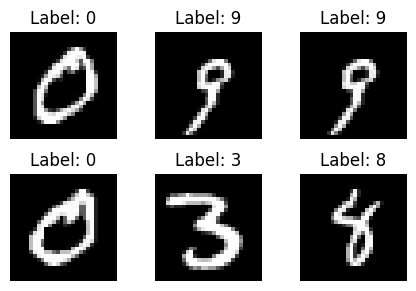

In [12]:
show_many_mnists([1,19,19,21,12,160])

## Pregatirea datelor - dataloader

Un DataLoader în PyTorch este o clasă care facilitează încărcarea datelor într-un model de învățare automată în timpul antrenării sau evaluării. Acesta oferă o abordare eficientă și convenabilă pentru a itera prin setul de date, împărțindu-l în loturi (batches) de dimensiuni fixe. Acest lucru ajută la gestionarea memoriei și la paralelizarea sarcinilor de prelucrare a datelor.

Iată o descriere a fiecărei componente a unui DataLoader în PyTorch:

1. **Setul de date (Dataset)**: Aceasta este clasa responsabilă pentru reprezentarea și accesul la datele tale. Aceasta trebuie să fie o subclasă a clasei torch.utils.data.Dataset și să implementeze metodele __len__ și __getitem__. În metoda __getitem__, se obțin datele corespunzătoare unui anumit index, de obicei returnând o pereche de intrare (exemplu) și etichetă.

2. **Transformările datelor (transforms)**: Aceasta este o serie de transformări aplicate asupra datelor pentru a le pregăti înainte de utilizare în modelul de învățare automată. PyTorch furnizează clasa torchvision.transforms care conține o varietate de transformări comune, cum ar fi convertirea în tensori și normalizarea.

3. **DataLoader**: Aceasta este clasa principală care preia setul de date și aplică diverse operații pentru a facilita procesul de încărcare a datelor. Parametrii importanți includ dimensiunea lotului (batch_size), opțiunea de amestecare (shuffle), numărul de procese pentru încărcarea datelor în paralel (num_workers), precum și alți parametri de control al memoriei și vitezei de încărcare.

Un DataLoader îți permite să iterezi prin loturile de date folosind o buclă for obișnuită. În fiecare iterație, vei primi un lot de dimensiune batch_size care conține intrări și etichete corespunzătoare. Acest lucru îți permite să antrenezi sau să evaluezi modelul utilizând aceste loturi de date.

Prin folosirea unui DataLoader, procesul de încărcare a datelor devine mai eficient și mai ușor de gestionat, permițându-ți să te concentrezi mai mult pe procesul de antrenare sau evaluare a modelului de învățare automată.

transformarile implica conversia catre tensor (tipul de date cu care opereaza PyTorch) si normalizarea datelor

Datasetul trebuie implementat obiectual, ca o clasa care subclaseaza clasa Dataset si implementeaza (obligatoriu) metoda __getitem__ si, recomandat, metoda __len__

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label



### Hiperparametrii

Hiperparametrii sunt variabile care influenteaza rezultatul modelarii

In [14]:
#forma rete;ei neuronale
input_size = 784
hidden_size = 500
num_classes = 10

#parametrii de antrenament
num_epochs = 10
batch_size = 100
learning_rate = 0.001

##Pregatim datele pentru a fi incorporate in dataset si dataloader

In [15]:
train_images = mnist_data['train_images']
train_labels = mnist_data['train_labels']
test_images = mnist_data['test_images']
test_labels = mnist_data['test_labels']


train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
test_dataset = MNISTDataset(test_images, test_labels, transform=transform)

# Data loadere

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)

Construim reteaua neuronala

In [16]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out



## Antrenarea modelului

## Criterion (functia de cost)

În contextul rețelelor neuronale, criterion se referă la funcția de cost, adică metoda prin care modelul evaluează cât de greșite sunt predicțiile sale în comparație cu valorile reale. În linia

```python
criterion = nn.CrossEntropyLoss()
```

se utilizează funcția de pierdere Cross Entropy (entropie încrucișată), care este potrivită pentru probleme de clasificare multi-clasă. Aceasta compară distribuția de probabilități generată de model pentru fiecare clasă cu eticheta corectă și calculează o valoare numerică ce reflectă cât de bine sau prost se comportă modelul. Această valoare este apoi folosită de optimizator pentru a ajusta parametrii modelului în direcția corectă.

## Optimizer

În învățarea automată, un optimizer (optimizator) este un algoritm care ajustează automat valorile parametrilor unui model, cum ar fi ponderile unei rețele neuronale, pentru a reduce eroarea dintre predicțiile modelului și valorile reale. În linia

```python
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```
se creează un optimizator de tip Adam, care este o versiune avansată și eficientă a algoritmului de tip gradient descendent. Parametrul model.parameters() îi spune optimizatorului ce valori să actualizeze, iar lr=learning_rate stabilește cât de mari să fie pașii de ajustare la fiecare iterație.

In [17]:

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Configuram functia de cost si optimizatorul
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Bucla propriu-zisa de antrenament
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # redimensionează fiecare imagine dintr-o matrice 2D de dimensiune 28x28 într-un vector unidimensional de lungime 784 (28 * 28 = 784)
        # to(device) se foloseste pentru a copia structurile de date in memoria dispozitivului folosit, fie cpu, fie cuda (daca avem o placa nvidia la dispozitie)
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # resetarea gradienților optimizatorului inainte de noua trecere prin model
        optimizer.zero_grad()

        # Trcem imaginile prin model obtinand rezultatele in variabila outputs
        outputs = model(images)

        # calculam pierderea (diferenta dintre detectie si adevar)
        loss = criterion(outputs, labels)

        # recalcularea coeficientilor astfel incat sa se micsoreze valoarea functiei de cost.
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))





/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Epoch [1/10], Step [100/600], Loss: 0.3655
Epoch [1/10], Step [200/600], Loss: 0.3259
Epoch [1/10], Step [300/600], Loss: 0.2362
Epoch [1/10], Step [400/600], Loss: 0.2770
Epoch [1/10], Step [500/600], Loss: 0.2195
Epoch [1/10], Step [600/600], Loss: 0.1035
Epoch [2/10], Step [100/600], Loss: 0.1610
Epoch [2/10], Step [200/600], Loss: 0.1590
Epoch [2/10], Step [300/600], Loss: 0.3049
Epoch [2/10], Step [400/600], Loss: 0.1925
Epoch [2/10], Step [500/600], Loss: 0.1019
Epoch [2/10], Step [600/600], Loss: 0.1315
Epoch [3/10], Step [100/600], Loss: 0.0986
Epoch [3/10], Step [200/600], Loss: 0.1540
Epoch [3/10], Step [300/600], Loss: 0.0971
Epoch [3/10], Step [400/600], Loss: 0.0781
Epoch [3/10], Step [500/600], Loss: 0.1028
Epoch [3/10], Step [600/600], Loss: 0.1276
Epoch [4/10], Step [100/600], Loss: 0.0504
Epoch [4/10], Step [200/600], Loss: 0.1379
Epoch [4/10], Step [300/600], Loss: 0.0879
Epoch [4/10], Step [400/600], Loss: 0.0524
Epoch [4/10], Step [500/600], Loss: 0.0377
Epoch [4/10

## Testarea modelului cu ajutorul datelor de test

In [18]:
# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    index = 0
    for images, labels in test_loader:
      if index > 2:
        break
      print('index: ' + str(index))
      images = images.reshape(-1, 28*28).to(device)
      labels = labels.to(device)
      outputs = model(images)
      print(outputs)
      print('label:' + str(labels))
      _, predicted = torch.max(outputs.data, 1)
      print(predicted)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      index += 1
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

index: 0
tensor([[ -5.2512,   2.1661,   2.8302,  -1.8966,  -7.4045, -13.0478,  -6.7794,
           2.2498,  -3.1139,  -4.5292]])
label:tensor([1], dtype=torch.uint8)
tensor([2])
index: 1
tensor([[ 17.2970, -17.9856,  -4.1806, -10.0027, -21.3850,  -1.5190,  -5.1682,
          -3.7142, -12.7447, -10.3451]])
label:tensor([0], dtype=torch.uint8)
tensor([0])
index: 2
tensor([[-14.5502, -10.1343,  -7.3636,  -9.4799,  11.7902,  -2.9662,  -7.0572,
          -2.8181,  -9.7298,   1.0050]])
label:tensor([4], dtype=torch.uint8)
tensor([4])
Accuracy of the network on the 10000 test images: 66.66666666666667 %


## Salvarea modelului

In [20]:

# Save the model checkpoint
model_name = str(num_epochs) + '_model.ckpt'
print(model_name)
torch.save(model.state_dict(), model_name)

10_model.ckpt


# Verificarea imaginilor de test

## Incarcarea modelului salvat

In [21]:
model_file = model_name #for now, this is the model that we have

print(model_file)
mnist_model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load(model_file)

mnist_model.load_state_dict(checkpoint)
mnist_model.eval()


10_model.ckpt


NeuralNet(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
print("Upload the test data")
uploaded_test_file = files.upload()  # Allows user to upload a file
# Get the first uploaded file
test_file_path = list(uploaded_test_file.keys())[0]

Upload the test data


TypeError: 'NoneType' object is not subscriptable

Incarcarea imaginilor de test

## Testam doar una dintre imaginile de test

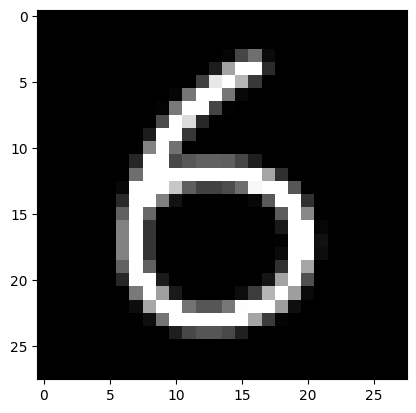

In [ ]:
singular_image = io.imread(test_file_path)

if singular_image.shape[2] == 4:
    # ditch the alpha channel
    singular_image = singular_image[:, :, :3]
    # convert to grayscale
    singular_image_gray = color.rgb2gray(singular_image)
elif singular_image.shape[2] == 2:
    # ditch the alpha channel
    singular_image_gray = singular_image[:, :, 0]
    plt.imshow(singular_image_gray, cmap='gray')
    plt.show()

In [ ]:
import torch.nn.functional as F
singular_image_array = np.array(singular_image_gray)          #transformam imaginea inapoi la matrice
singular_image_flattened = singular_image_array.reshape(1,28*28)

singular_image_flattened = transform(singular_image_flattened)
output = mnist_model(singular_image_flattened)
print(output)
_, predicted = torch.max(output.data[0], 1)
print(f"Predicted: {predicted.item()}")

tensor([[[ -4.6453, -11.9559, -12.0460,  -0.7680, -10.6108,   7.6711,  -3.5713,
           -7.4012,  -2.0367,  -2.6809]]], grad_fn=<ViewBackward0>)
Predicted: 5
